# Choropleth is Here!!

First we will import all the packages we will need.  


Only in Google Colaboratory, run the two cells below:

    !pip install geopandas
    
    import os ...

*Note, I have added the `warnings` package to suppress the version number warnings that are likely to arise for the newer version of folium that is used on Google Colaboratory.*



In [0]:
!pip install geopandas

In [3]:
import os
from urllib.request import urlretrieve

os.mkdir('data')

gala_zip_data = "https://github.com/BrianArbuckle/GALA/blob/master/data/gala_zip_df_2018_2019.pkl"

urlretrieve(gala_zip_data, 'data/gala_zip_df_2018_2019.pkl')


('data/gala_zip_df_2018_2019.pkl', <http.client.HTTPMessage at 0x7fc24145fc50>)

In [0]:
import pandas as pd
import geopandas as gpd

import folium
from folium import plugins

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

### Our Basic Variables

In [0]:
GALA_Address = '1067 West Blvd, Los Angeles, CA 90019'

gala_lat = 34.05544
gala_long = -118.33132

## Importing the pickle file we made last week.  

The **gala_zip_df_2018_2019.pkl** is the file we made, which contains all the Los Angeles Zip Codes, The Number of Students per Zip Code, as well as the geometry for each zip code.  Though the geometry is saved in the DataFrame, we need to re-convert it to a GeoDataFrame with <code>GeoDataFrame()</code> method in the geopandas package.  


## Geodetic Systems / Coordinate Reference Systems

This requires a little behind the scenes wizardry, of assigning the Geodetic System.  A geodetic system is a coordinate system, and a set of reference points, used to locate places on the Earth. 

### Isn't this the same thing as the latitude and longitude coordinate system?!:

YES!  However, there a several ways these have been created.  The "Popular" system is the WGS84, World Geodetic System 1984, and is used in GPS.  However, the data set that matches actual maps, were created, in this popular coordinate system by The EPSG, or the European Petroleum Survey Group, and they have named their version of WGS 84 as EPSG:4326.  For most projects, this is what you will use as your Coordinate Reference Systems or CRS. 

All we need to know, is that when reconverting our DataFrame to a GeoDataFrame, it requires setting the crs to 'epsg:4326'


In [0]:
gala_zip_df = pd.read_pickle("data/gala_zip_df_2018_2019.pkl")

la_geo_df = gpd.GeoDataFrame(gala_zip_df, crs = {'init': 'epsg:4326'}, geometry=gala_zip_df.geometry)

# Clean Slate

Let's start with a clean version of the folium map we used in the original bubble map:

In [0]:
gala_map = folium.Map(location=[gala_lat, gala_long],
                        zoom_start=11,
                        tiles="CartoDB positron", min_zoom =8)

folium.Marker(location=[gala_lat, gala_long], 
              icon=folium.Icon(color='black', icon='graduation-cap', prefix='fa'), 
              popup = GALA_Address).add_to(gala_map)

gala_map

# Adding the Choropleth

Using the <code>choropleth()</code> method on the Map Class, we can show of our data on the map. 

Here is the basic code. Let’s go through the arguments, and discuss way to improve the choropleth.

In [0]:
folium.Map.choropleth(
    gala_map,
    geo_data=la_geo_df,
    name='choropleth',
    data=gala_zip_df,
    columns=[gala_zip_df.index, 'Number of Students'],
    key_on='feature.id',
    fill_color='YlGnBu')

gala_map

## <code>describe()</code>
Though this looks pretty cool, this distribution of the data is skewed by the outliers in the data. There is little variation in the data ranges, because of this.


We can examine the data with the pandas <code>describe()</code> method to see what is going on.

In [0]:
gala_zip_df.describe()

,Number of Students,Latitude,Longitude
count,64.000000,64.000000,64.000000
mean,7.015625,34.020977,-118.310561
std,9.720690,0.063745,0.085194
min,1.000000,33.860000,-118.540000
25%,2.000000,33.970000,-118.370000
50%,4.000000,34.031250,-118.310000
75%,8.250000,34.070000,-118.257500
max,66.000000,34.130000,-118.050000


Here we can see the maximum is 66 students per zip code.   While the median is 4!!! We have some serious outliers.

Let's visualize the data little differently:

### Box plots

We can show the distribution of the number of students per zip code, in a more meaningful way, than just the raw numbers.

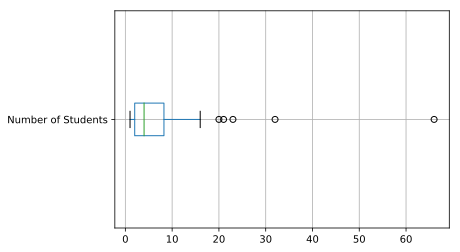

In [0]:
gala_zip_df.boxplot(column=['Number of Students'], vert=False)

## threshold_scale

The threshold_scale is an argument in the folium where you can set the peak value, in this case the number of students, for the 6 avaialble colors.  Looking at the box plot, let's discuss the options and re-render the map, and add the values to to the threshold_scale. 

This time I have added a couple ofthe argument to adjust the fill opacity, the line opacity as well as adding a highlight feature when overing over a zip code.

Take note, that we need to re-render all the map layers or they will just be added to the previous render.

In [0]:
gala_map = folium.Map(location=[gala_lat - .02, gala_long],
                        zoom_start=11,
                        tiles="CartoDB positron")


folium.Marker(location=[gala_lat, gala_long], 
              icon=folium.Icon(color='black', icon='graduation-cap', prefix='fa'), 
              popup = GALA_Address).add_to(gala_map)

folium.Map.choropleth(
    gala_map,
    geo_data=la_geo_df,
    name='choropleth',
    data=gala_zip_df,
    columns=[gala_zip_df.index, 'Number of Students'],
    key_on='feature.id',
    fill_color='YlGnBu',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Number of GALA Students per Zip Code', threshold_scale = [0, 2, 4, 15, 30, 67], highlight=True)

gala_map

In [0]:
for zip_code in la_geo_df.index:
    folium.CircleMarker(location=[la_geo_df.loc[zip_code][1], 
                                  la_geo_df.loc[zip_code][2]], 
                        fill=True,
                        popup= str(zip_code) + '<br>' + str(la_geo_df.loc[zip_code][0]) + '\n Students',
                        color='#65318f', 
                        radius = 4,
                        opacity=.2).add_to(gala_map)

gala_map